In [86]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, plot_roc_curve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium 

In [2]:
df = pd.read_csv('cleaned_crash_data.csv')

# Data Preperation

In [3]:
X = df.drop('INJURIES_FATAL',axis=1)
y = df.INJURIES_FATAL

# train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### One Hot Encoding 

In [5]:
#Ohe-ing Train set
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums_train = ohe.fit_transform(X_train_cat)
dums_train_df = pd.DataFrame(dums_train,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

nums_train_df = X_train.select_dtypes(['int64','float64'])

X_train_clean = pd.concat([nums_train_df, dums_train_df], axis=1)

In [6]:
#Ohe-ing Test set
X_test_cat = X_test.select_dtypes('object')

dums_test = ohe.transform(X_test_cat)
dums_test_df = pd.DataFrame(dums_test,
                       columns=ohe.get_feature_names(),
                       index=X_test_cat.index)

nums_test_df = X_test.select_dtypes(['int64','float64'])

X_test_clean = pd.concat([nums_test_df, dums_test_df], axis=1)

# Dummy Classfier 

In [156]:
dummy = DummyClassifier(random_state=42) 

#establishing random_state for reproducibility
dummy.fit(X_train_clean, y_train)
y_pred = dummy.predict(X_test_clean)

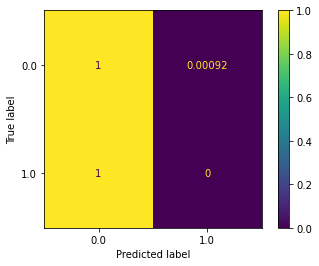

In [157]:
plot_confusion_matrix(estimator=dummy, X=X_test_clean, y_true=y_test, normalize='true');

In [158]:
y_train.value_counts(normalize=True)

0.0    0.998928
1.0    0.001072
Name: INJURIES_FATAL, dtype: float64

In [159]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9977578704888661


### SMOTE

In [7]:
# X_train_clean.columns
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_clean, y_train) 

# Dummy Classfier with SMOTE

In [148]:
dummy_smote = DummyClassifier(random_state=42)
dummy_smote.fit(X_train_resampled, y_train_resampled)
y_pred_dummy_sm = dummy_smote.predict(X_test)

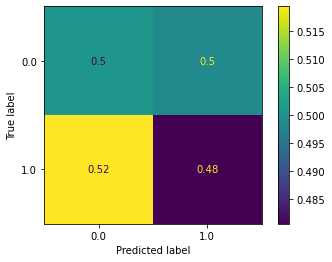

In [149]:
plot_confusion_matrix(estimator=dummy_smote, X=X_test_clean, y_true=y_test, normalize='true');

In [150]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred_dummy_sm)))

Accuracy Score: 0.5009367801382134


# Decision Tree

In [105]:
tree = DecisionTreeClassifier()

In [106]:
tree_grid = {'max_leaf_nodes': [4, 5, 6, 7], 
             'min_samples_split': [2, 3, 4],
             'max_depth': [2, 3, 4, 5],
            }

In [107]:
tree_grid_search = GridSearchCV(tree, tree_grid, cv=5)

In [108]:
tree_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4]})

In [109]:
tree_grid_search.best_params_

{'max_depth': 5, 'max_leaf_nodes': 7, 'min_samples_split': 2}

In [110]:
tree_grid_search.best_score_

0.9023948618086161

In [111]:
tree_grid_search.best_estimator_.score(X_test_clean, y_test)

0.917952393140517

In [112]:
best_tree = tree_grid_search.best_estimator_

In [113]:
tree_test_preds = best_tree.predict(X_test_clean)

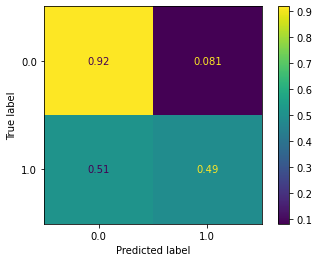

In [136]:
plot_confusion_matrix(best_tree, X_test_clean, y_test, normalize='true')
plt.savefig('images/tree_conf_matrix.png');

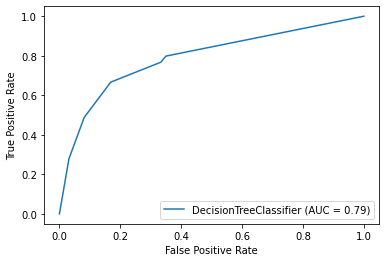

In [137]:
plot_roc_curve(best_tree, X_test_clean, y_test)
plt.savefig('images/tree_roc.png');

In [116]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [117]:
print_metrics(y_test, tree_test_preds)

Precision Score: 0.007864186743228061
Recall Score: 0.4883720930232558
Accuracy Score: 0.917952393140517
F1 Score: 0.015479115479115478


In [125]:
tree_features = list(zip(best_tree.feature_importances_, X_train_resampled.columns.values))
tree_features = sorted(tree_features, key=lambda x: x[0], reverse=True)
tree_features_values = [x[0] for x in tree_features][:4]
tree_features_names = [x[1] for x in tree_features][:4]

In [126]:
df.head()

,AGE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFIC_CONTROL_DEVICE,PHYSICAL_CONDITION,VEHICLE_DEFECT,LONGITUDE,LATITUDE,INJURIES_FATAL
0,31.0,17,4,7,35,CLEAR,DAYLIGHT,NO CONTROLS,NORMAL,UNKNOWN,-87.773288,41.919664,0.0
1,20.0,16,6,6,35,CLEAR,DAYLIGHT,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,-87.740954,41.741804,0.0
2,50.0,10,6,7,30,CLEAR,DAYLIGHT,TRAFFIC SIGNAL,NORMAL,UNKNOWN,-87.585022,41.773456,0.0
3,36.0,1,7,7,30,CLEAR,DARKNESS,NO CONTROLS,UNKNOWN,NONE,-87.622115,41.802119,0.0
4,45.0,22,5,3,30,CLEAR,"DARKNESS, LIGHTED ROAD",TRAFFIC SIGNAL,NORMAL,UNKNOWN,-87.740954,41.741804,0.0


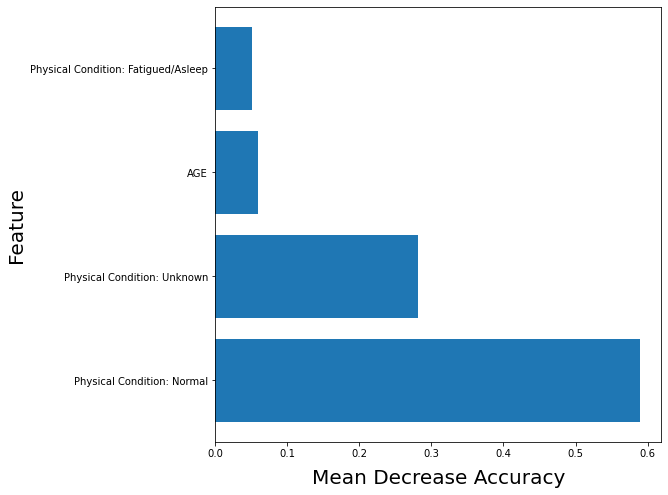

In [135]:
plt.figure(figsize=(8,8))
tree_labels = ['Physical Condition: Normal', 'Physical Condition: Unknown', 'AGE',
               'Physical Condition: Fatigued/Asleep']
plt.barh(tree_features_names, tree_features_values, align='center', tick_label=tree_labels)
plt.xlabel('Mean Decrease Accuracy', fontsize=20, labelpad=10)
plt.ylabel('Feature', fontsize=20)
plt.savefig('images/tree_feature_plot.png');

In [128]:
tree_cv_df = pd.DataFrame(tree_grid_search.cv_results_)
tree_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.977304,0.139740,0.019456,0.002555,2,4,2,"{'max_depth': 2, 'max_leaf_nodes': 4, 'min_sam...",0.850424,0.851722,0.85144,0.851414,0.850116,0.851023,0.000632,37
1,0.897817,0.008857,0.017474,0.000178,2,4,3,"{'max_depth': 2, 'max_leaf_nodes': 4, 'min_sam...",0.850424,0.851722,0.85144,0.851414,0.850116,0.851023,0.000632,37
2,0.887219,0.007858,0.017654,0.000324,2,4,4,"{'max_depth': 2, 'max_leaf_nodes': 4, 'min_sam...",0.850424,0.851722,0.85144,0.851414,0.850116,0.851023,0.000632,37
3,0.894236,0.010971,0.017588,0.000127,2,5,2,"{'max_depth': 2, 'max_leaf_nodes': 5, 'min_sam...",0.850424,0.851722,0.85144,0.851414,0.850116,0.851023,0.000632,37
4,0.887710,0.005493,0.017568,0.000326,2,5,3,"{'max_depth': 2, 'max_leaf_nodes': 5, 'min_sam...",0.850424,0.851722,0.85144,0.851414,0.850116,0.851023,0.000632,37


# Random Forest

In [24]:
forest = RandomForestClassifier()

In [81]:
# The number of features to consider when looking for the best split
max_features = ['sqrt', 'log2']

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
forrest_grid = {'max_features': max_features,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

In [26]:
forrest_grid_search = GridSearchCV(estimator=forest, param_grid=forrest_grid, cv=5)

In [27]:
forrest_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [95]:
forrest_grid_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

In [96]:
forrest_grid_search.best_score_

0.9994345939667246

In [98]:
best_forest = forrest_grid_search.best_estimator_

In [99]:
forrest_test_preds = forrest_grid_search.predict(X_test_clean)

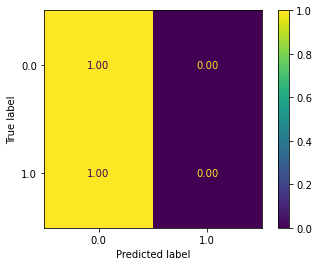

In [133]:
plot_confusion_matrix(best_forest, X_test_clean, y_test, normalize='true', values_format = '.2f')
plt.savefig('images/forrest_conf_matrix.png');

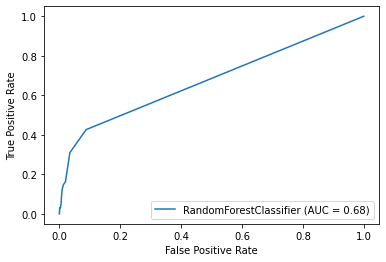

In [138]:
plot_roc_curve(best_forest, X_test_clean, y_test)
plt.savefig('images/forest_roc.png');

In [47]:
print_metrics(y_test, forrest_test_preds)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.9986485794727412
F1 Score: 0.0


In [82]:
forrest_features = list(zip(best_forest.feature_importances_, X_train_resampled.columns.values))
forrest_features = sorted(forrest_features, key=lambda x: x[0], reverse=True)
forrest_features_values = [x[0] for x in forrest_features][:5]
forrest_features_names = [x[1] for x in forrest_features][:5]

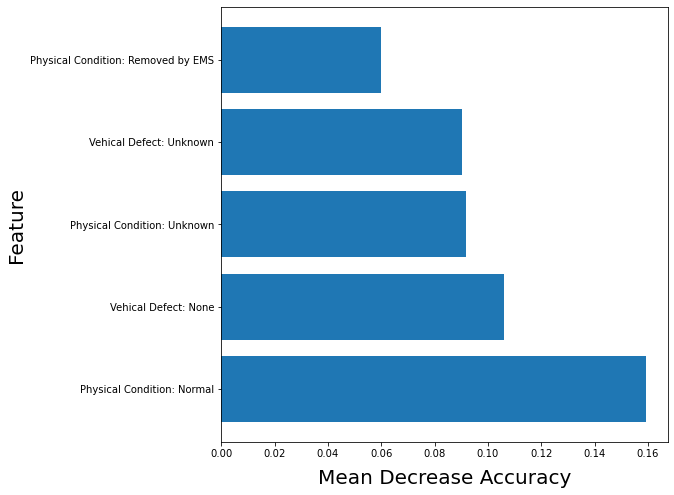

In [134]:
plt.figure(figsize=(8,8))
forrest_labels = ['Physical Condition: Normal', 'Vehical Defect: None', 'Physical Condition: Unknown',
                  'Vehical Defect: Unknown','Physical Condition: Removed by EMS']

plt.barh(forrest_features_names, forrest_features_values, align='center', tick_label=forrest_labels)
plt.xlabel('Mean Decrease Accuracy', fontsize=20, labelpad=10)
plt.ylabel('Feature', fontsize=20)
plt.savefig('images/forest_feature_plot.png');

In [50]:
forest_cv_df = pd.DataFrame(forrest_grid_search.cv_results_)
forest_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,41.850999,0.761358,0.984590,0.030435,sqrt,1,2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997352,0.999966,0.999966,0.999940,0.999949,0.999435,0.001041,1
1,41.781056,1.573100,0.981821,0.030089,sqrt,1,5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997369,0.999932,0.999974,0.999915,0.999932,0.999424,0.001028,3
2,41.867234,0.875400,0.980139,0.027985,sqrt,1,10,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997378,0.999923,0.999957,0.999923,0.999915,0.999419,0.001021,4
3,41.255589,1.402057,0.959210,0.034043,sqrt,2,2,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.997395,0.999880,0.999915,0.999872,0.999898,0.999392,0.000999,7
4,42.523286,1.516671,0.955736,0.028170,sqrt,2,5,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.997369,0.999932,0.999898,0.999855,0.999906,0.999392,0.001012,7


In [ ]:
plot_columns = []